# Analysis of Tempo (aka Duration)

## Imports

In [5]:
import pandas as pd
import numpy as np

## Reading

In [6]:
def read_to_numpy_with_headers(file_path):
    df = None
    if (file_path[-5:] == '.xlsx'):
        df = pd.read_excel(file_path)
    elif (file_path[-4:] == '.csv'):
        df = pd.read_csv(file_path)
    columns_to_drop = ['FullDateTime']
    df = df.drop(columns_to_drop, axis=1)
    headers = df.columns.values  # Extract headers

    return df, headers

In [7]:
file_path = "../../../data/etp-bermant.csv"
initial_df, headers = read_to_numpy_with_headers(file_path)

initial_df.shape, headers

((16995, 17),
 array(['CodaNum', 'ClanNum', 'ClanName', 'NumClicks', 'TotalDur', 'ICI1',
        'ICI2', 'ICI3', 'ICI4', 'ICI5', 'ICI6', 'ICI7', 'ICI8', 'ICI9',
        'ICI10', 'ICI11', 'Coda Type'], dtype=object))

## Processing

Process tempos only for EC1 clan

In [11]:
all_tempos = initial_df['TotalDur'].astype(float)

# Extract the clan labels from the dataset
clans = initial_df['ClanName']

# Only use codas (tempos) from the EC1 clan
all_tempos_labelled = []

for i in range(len(clans)):
    if clans[i] == 'Regular':  # Check if the clan is 'EC1'
        all_tempos_labelled.append(all_tempos[i])

# Filter out anomalous annotations by limiting tempos to a specific range
all_tempos_ec1 = []

# Loop through all EC1 clan tempos and apply the filtering criteria
for i in range(len(all_tempos_labelled)):
    if 0.1 < all_tempos_labelled[i] < 1.75:  # Only keep tempos between 0.1 and 1.75
        all_tempos_ec1.append(all_tempos_labelled[i])

f"Number of codas from the Regular clan: {len(all_tempos_ec1)}"

'Number of codas from the Regular clan: 6306'

Visualize distribution

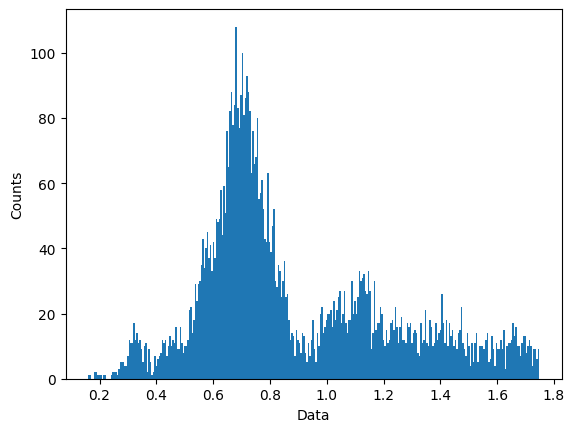

In [12]:
import matplotlib.pyplot as plt

# Plot the histogram to show distribution of tempo values
plt.hist(all_tempos_ec1, bins=300)
plt.ylabel('Counts')
plt.xlabel('Data')
plt.show()

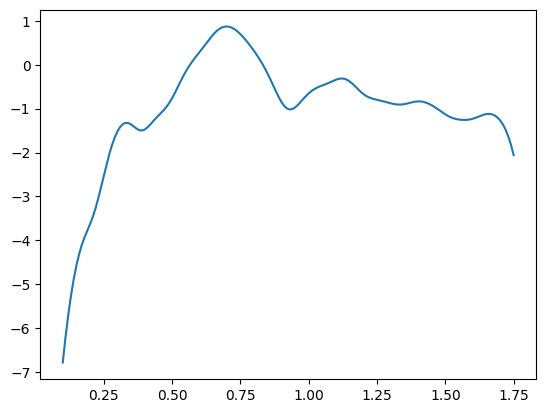

In [13]:
from numpy import array
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot

a = array(all_tempos_ec1).reshape(-1, 1)

# Apply Kernel Density Estimation (KDE) with a Gaussian kernel to estimate the probability density function of the tempos
kde = KernelDensity(kernel='gaussian', bandwidth=0.035).fit(a)
# 'gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'

# Create a range of values (s) over which to evaluate the KDE, spanning the tempo range from 0.1 to 1.75
s = np.arange(0.1, 1.75 + 0.01, 0.01)

# Evaluate the log density (e) of the KDE at each point in 's'
e = kde.score_samples(s.reshape(-1, 1))

# Plot the KDE results, showing how the probability density varies across the tempo range
plot(s, e)
plt.show()

In [14]:
from scipy.signal import argrelextrema

# Identify local minima and maxima in the estimated log density (e)
# 'argrelextrema' finds indices of relative extrema (minima or maxima) in an array

# Find indices of local minima in the density estimate 'e'
mi = argrelextrema(e, np.less)[0]

# Find indices of local maxima in the density estimate 'e'
ma = argrelextrema(e, np.greater)[0]

# This gives the tempo values where the density changes from increasing to decreasing (maxima)
# or decreasing to increasing (minima)
print("Minima:", s[mi])
print("Maxima:", s[ma])

Minima: [0.39 0.93 1.33 1.57]
Maxima: [0.33 0.7  1.12 1.4  1.66]


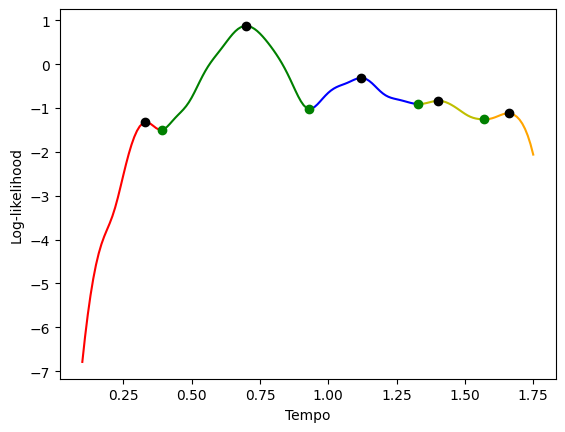

In [15]:
# Plot segments of the KDE curve between each pair of local minima (mi) using different colors

plot(s[:mi[0]+1], e[:mi[0]+1], 'r')
plot(s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g')
plot(s[mi[1]:mi[2]+1], e[mi[1]:mi[2]+1], 'b')
plot(s[mi[2]:mi[3]+1], e[mi[2]:mi[3]+1], 'y')
plot(s[mi[3]:], e[mi[3]:], 'orange')
plot(s[ma], e[ma], 'ko')
plot(s[mi], e[mi], 'go')

plt.ylabel("Log-likelihood")
plt.xlabel("Tempo")
plt.show()

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tempo_clustering(intervals, all_tempos):
    # Define the intervals based on the KDE minima positions
    # These intervals span from the minimum tempo value (0.1) to the maximum (1.75),
    # with each interval boundary set at a local minimum of the KDE curve.
    intervals = [0.1, *intervals, 1.75]

    plt.figure()
    # Define colors for each interval to match the KDE segmentation
    colors = ['red', 'green', 'blue', 'yellow', 'orange', 'violet', 'brown', 'pink']

    # Plot a histogram for each interval with a different color
    for i in range(len(intervals) - 1):
        # Filter all tempos to include only data points within the current interval
        interval_data = [tempo for tempo in all_tempos if intervals[i] <= tempo < intervals[i + 1]]
        plt.hist(interval_data, bins=100, color=colors[i], alpha=0.7, label=f"{intervals[i]:.2f} - {intervals[i+1]:.2f}")

    plt.ylabel('Counts')
    plt.xlabel('Data')
    plt.legend(title="Tempo Intervals")
    plt.show()

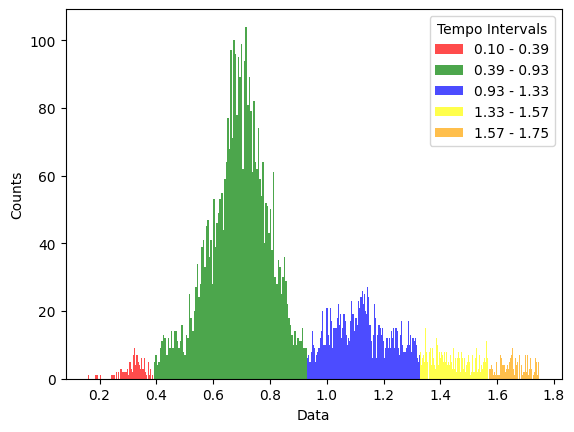

In [17]:
# Define the intervals based on the KDE minima positions
# These intervals span from the minimum tempo value (0.1) to the maximum (1.75),
# with each interval boundary set at a local minimum of the KDE curve.
intervals = [s[mi[0]], s[mi[1]], s[mi[2]], s[mi[3]]]

plot_tempo_clustering(intervals, all_tempos_ec1)

In [18]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Fit GMM to 1D data
data = np.array(all_tempos_ec1).reshape(-1, 1)
gmm = GaussianMixture(n_components=5, random_state=0).fit(data)

# Extract and sort cluster centers
centers = np.sort(gmm.means_.flatten())

# Calculate midpoints between consecutive centers to define interval boundaries
intervals = [(centers[i] + centers[i+1]) / 2 for i in range(len(centers) - 1)]
print("GMM interval boundaries:", intervals)

GMM interval boundaries: [np.float64(0.6079194216240015), np.float64(0.8978328506401557), np.float64(1.2214067560211093), np.float64(1.4905810438191303)]


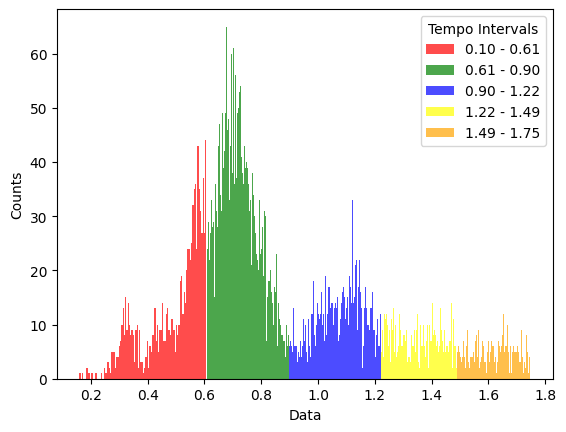

In [19]:
plot_tempo_clustering(intervals, all_tempos_ec1)

In [20]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Fit Agglomerative Clustering on 1D data
agg_clustering = AgglomerativeClustering(n_clusters=5)
labels = agg_clustering.fit_predict(data)

# Calculate the mean of each cluster
centers = np.array([data[labels == i].mean() for i in range(5)])
centers.sort()

# Calculate midpoints between consecutive centers to define intervals
intervals = [(centers[i] + centers[i+1]) / 2 for i in range(len(centers) - 1)]
print("Agglomerative interval boundaries:", intervals)


Agglomerative interval boundaries: [np.float64(0.6265214670247823), np.float64(0.8641098416494344), np.float64(1.087846604264041), np.float64(1.3504698254296645)]


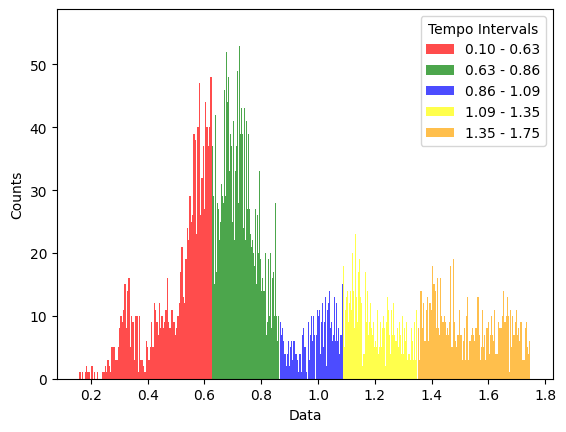

In [21]:
plot_tempo_clustering(intervals, all_tempos_ec1)

# Rhythm Analysis

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import IPython

import numpy as np
import os
from IPython.display import Image as Image2
from numpy import genfromtxt 
import pickle
from IPython import embed
from PIL import Image, ImageDraw, ImageFont 

import seaborn as sn
import pandas as pd
%matplotlib inline
from scipy import ndimage
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.patches as mpatches
from collections import Counter

In [9]:
my_data = genfromtxt(file_path, delimiter=',',dtype=None,encoding="utf8")
my_data[0,:]

array(['CodaNum', 'FullDateTime', 'ClanNum', 'ClanName', 'NumClicks',
       'TotalDur', 'ICI1', 'ICI2', 'ICI3', 'ICI4', 'ICI5', 'ICI6', 'ICI7',
       'ICI8', 'ICI9', 'ICI10', 'ICI11', 'Coda Type'], dtype='<U19')

In [10]:
c_types = []

for i in range(1,my_data.shape[0]):
    curr_clan = my_data[i,3]
    
    if curr_clan=="Regular":
        c_types.append(str(my_data[i,-1]))

In [11]:
Counter(c_types)

Counter({'599.0': 3859,
         '899.0': 521,
         '81.0': 450,
         '799.0': 327,
         '72.0': 288,
         '699.0': 237,
         '62.0': 161,
         '61.0': 153,
         '71.0': 147,
         '499.0': 138,
         '999.0': 113,
         '1099.0': 91,
         '92.0': 88,
         '91.0': 84,
         '399.0': 60,
         '101.0': 53,
         '111.0': 48,
         '121.0': 35,
         '131.0': 19,
         '141.0': 11,
         '41.0': 11,
         '42.0': 7,
         '64.0': 7,
         '51.0': 6,
         '191.0': 5,
         '1199.0': 5,
         '151.0': 5,
         '112.0': 4,
         '82.0': 4,
         '32.0': 4,
         '161.0': 3,
         '221.0': 2,
         '181.0': 2,
         '102.0': 2,
         '201.0': 1,
         '31.0': 1,
         '171.0': 1,
         '33.0': 1,
         '43.0': 1})

In [17]:
# 6 13 13 11 11 9 10 9 11 3 15 17 14 15 1 16 17 18 -1 -1 3 -2 6 -3 -1 -3 13 1 -1 -1 -1 17 -1 0 -1 0 -2
rhythm = {
    '599.0': 6,
    '899.0': 13,
    '81.0': 13,
    '799.0': 11,
    '72.0': 11,
    '699.0': 9,
    '62.0': 10,
    '61.0': 9,
    '71.0': 11,
    '499.0': 3,
    '999.0': 15,
    '1099.0': 17,
    '92.0': 14,
    '91.0': 15,
    '399.0': 1,
    '101.0': 16,
    '111.0': 17,
    '121.0': 18,
    '131.0': -1,
    '141.0': -1,
    '41.0': 3,
    '42.0': -2,
    '64.0': 6,
    '51.0': -3,
    '191.0': -1,
    '1199.0': -3,
    '151.0': 13,
    '112.0': 1,
    '82.0': -1,
    '32.0': -1,
    '161.0': -1,
    '221.0': 17,
    '181.0': -1,
    '102.0': 0,
    '201.0': -1,
    '31.0': 0,
    '171.0': -1,
    '33.0': 0,
    '43.0': -2
}

rhythm = {
    '599.0': 0,
    '899.0': 1,
    '81.0': 2,
    '799.0': 3,
    '72.0': 4,
    '699.0': 5,
    '62.0': 6,
    '61.0': 7,
    '71.0': 8,
    '499.0': 9,
    '999.0': 10,
    '1099.0': 11,
    '92.0': 12,
    '91.0': 13,
    '399.0': 14,
    '101.0': 15,
    '111.0': 16,
    '121.0': 17,
    '131.0': 18,
    '141.0': 19,
    '41.0': 20,
    '42.0': 21,
    '64.0': 22,
    '51.0': 23,
    '191.0': 24,
    '1199.0': 25,
    '151.0': 26,
    '112.0': 27,
    '82.0': 28,
    '32.0': 29,
    '161.0': 30,
    '221.0': 31,
    '181.0': 32,
    '102.0':33,
    '201.0': 34,
    '31.0': 35,
    '171.0': 36,
    '33.0': 37,
    '43.0': 38
}

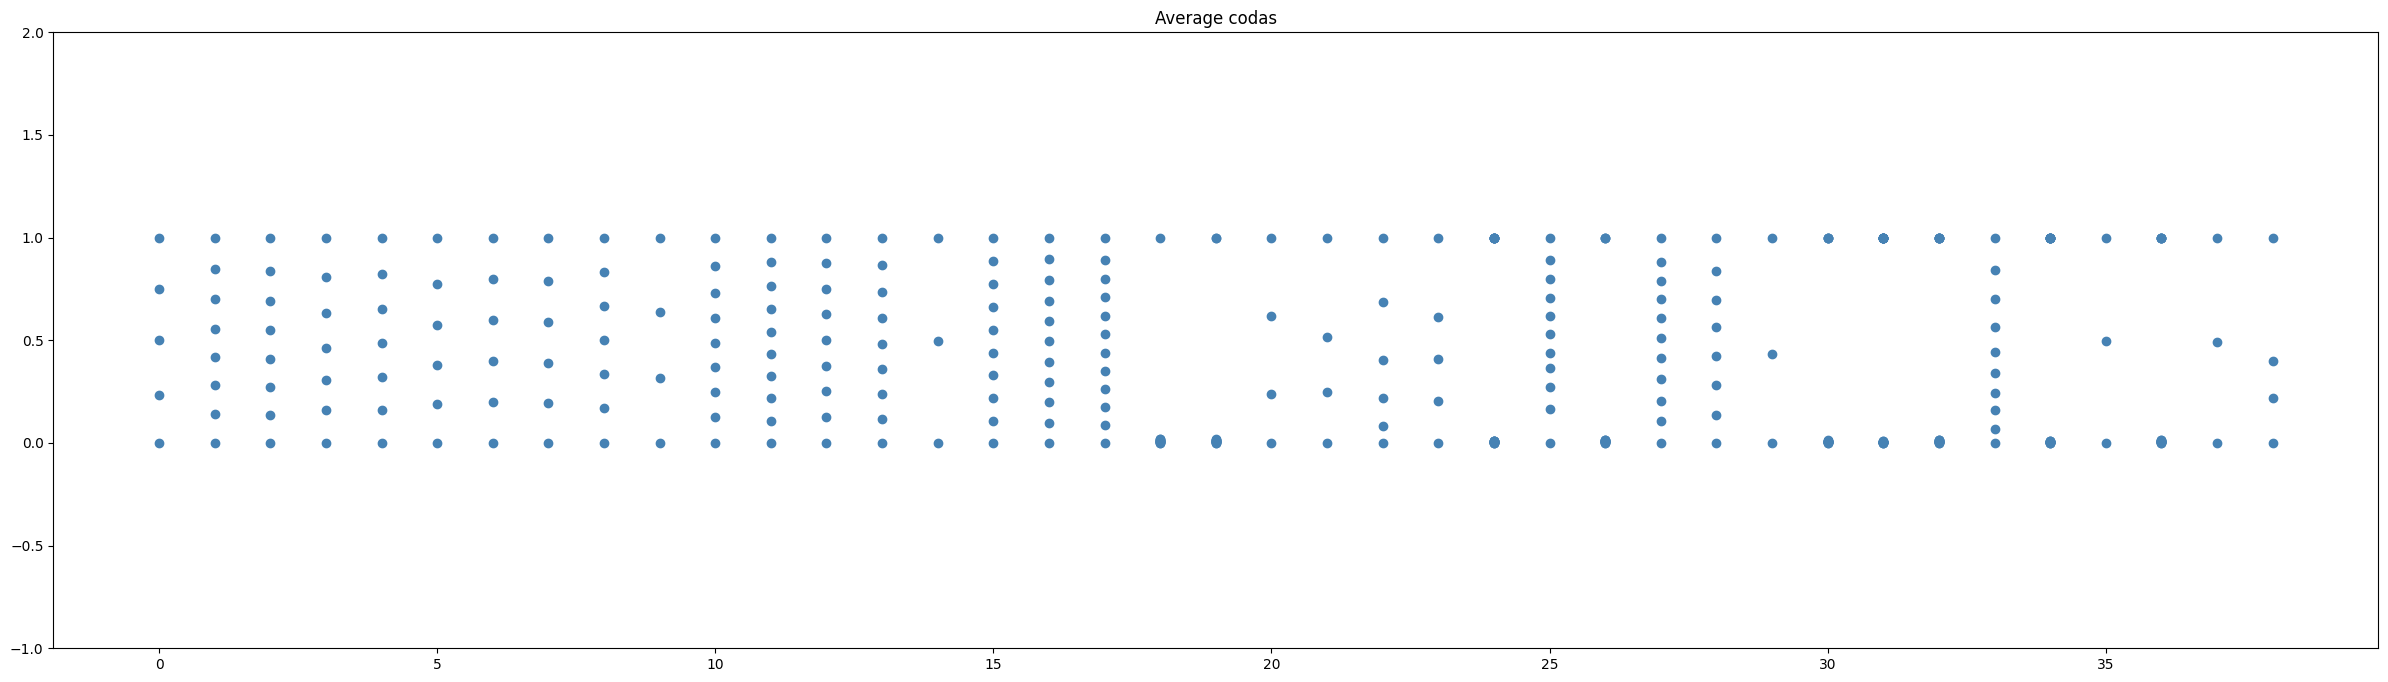

In [18]:
all_rhythms = []
mean_codas = []
all_types = set(c_types)
def return_relative(idx):
    n_clicks = my_data[idx,4].astype(int)
    rel_ICI = []
    rel_ICI.append(0)
    for t in range(7,6+n_clicks):
        rel_ICI.append(np.sum(my_data[idx,6:t].astype(float)))
    return rel_ICI

fig = plt.figure(figsize=(30, 8))
for ctype in all_types:
    rhy = rhythm[ctype]
#     print(ctype,rhy)
    if rhy!=-1 and rhy not in all_rhythms:
        all_rhythms.append(rhy)
        relative_ICI_vect = []
        for i in range(1,my_data.shape[0]):
            curr_clan = my_data[i,3]
            if curr_clan=="Regular" and my_data[i,-1]==str(ctype):
                if max(return_relative(i))!=0:
                    relative_ICIs = return_relative(i)/max(return_relative(i))
                    if len(relative_ICI_vect)==0 or len(relative_ICI_vect[-1])==len(relative_ICIs):
                        relative_ICI_vect.append(relative_ICIs)
                        x = len(relative_ICIs)*[rhy]
#         print(len(x),len(np.mean(np.array(relative_ICI_vect),0)))
        plt.scatter(x,np.mean(np.array(relative_ICI_vect),0),color='steelblue')
        mean_codas.append(np.mean(np.array(relative_ICI_vect),0))
plt.ylim(-1,2)
plt.title('Average codas')
plt.show()

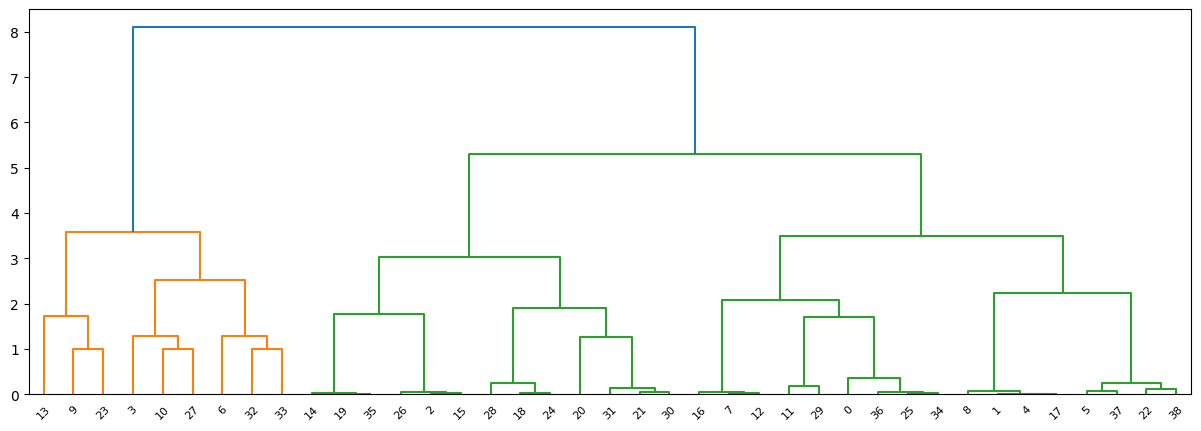

In [25]:
# Plot the dendrogram visualization of the codas

import scipy.cluster.hierarchy as sch

new_codas = []

max_len = 0
for i in mean_codas:
    max_len = max(max_len, len(i))

for i in range(len(mean_codas)):
    new_codas.append(list(mean_codas[i])+(max_len-len(mean_codas[i]))*[0])
    
X = np.array(new_codas)
Z = sch.linkage(X, method='ward')
fig = plt.figure(figsize=(15, 5))
dn = sch.dendrogram(Z,)
# plt.show()